# KVLCC2 eddy damping $\sigma$

# Purpose
The ikeda eddy damping seems to be sensitive to section coefficient $\sigma$ which is showen in this notebook.

# Methodology
Make a variation of $\sigma$ for the mid section of KVLCC2

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import shipflowmotionshelpers.preprocess as preprocess


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [7]:
import joblib
from src.helpers import get_ikeda, calculate_ikeda, get_estimator_variation, get_data_variation 
from rolldecayestimators import fit_on_amplitudes
from copy import deepcopy
from rolldecayestimators.ikeda import Ikeda, IkedaR, IkedaCarlJohan, IkedaBarge, IkedaBeSimplified
import rolldecayestimators.ikeda_speed
import scipy
import rolldecayestimators.ikeda_speed

## Load MDL results

In [126]:
db = database.get_db()

sql = """
SELECT * from run
INNER JOIN loading_conditions
ON (run.loading_condition_id = loading_conditions.id)
INNER JOIN models
ON (run.model_number = models.model_number)
INNER JOIN ships
ON (run.ship_name = ships.name)
WHERE run.model_number='M5057-01-A' and run.test_type='roll decay' and run.project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine)
df_rolldecays['rho']=1000
df_rolldecays['g']=9.81
df_rolldecays=df_rolldecays.loc[:,~df_rolldecays.columns.duplicated()]
df_rolldecays.set_index('id', inplace=True)

df_rolldecays['ship_speed'].fillna(0, inplace=True)
df_rolldecays['R'] = 2.4 # Bilge keel radius measured on geometry (full scale)

df_rolldecays=df_rolldecays.loc[[21338,21340,]].copy()

In [127]:
run = df_rolldecays.iloc[0]

In [141]:
scale_factor = run.scale_factor
beam = np.array([run.beam/scale_factor])
draught = np.array([run.TA/scale_factor])
sigma = 0.99
S_s = sigma*beam*draught

a, a_1, a_3, sigma_s, H = rolldecayestimators.ikeda_speed.calculate_sectional_lewis(B_s=beam, T_s=draught, S_s=S_s)

lewis = pd.Series()

lewis['a']=float(a)
lewis['a_1']=a_1[0]
lewis['a_3']=a_3[0]
lewis['sigma']=sigma_s[0]
lewis['H0']=H[0]
lewis['Ts']=draught[0]
lewis['Bs']=beam[0]
lewis['R_b']=2.4/scale_factor


c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


In [142]:
N = 1000
df_frame = pd.DataFrame(data = np.tile(lewis,(N,1)), columns=lewis.index)
df_frame['sigma'] = np.linspace(0.6,1,N)
#df_frame = df_frame.astype(float)

In [143]:
phi_a = np.deg2rad(10)
w = 2.4621496310208086
OG = 0.032352941176470584

df_frame['B_E0_s'] = rolldecayestimators.ikeda_speed.eddy_sections(bwl=df_frame.Bs, a_1=df_frame.a_1, a_3=df_frame.a_3, sigma=df_frame.sigma, H0=df_frame.H0, Ts=df_frame.Ts, 
                                                  OG=OG, 
                                                  R=df_frame.R_b, 
                                                  wE=w, 
                                                  fi_a=phi_a)
df_frame.set_index('sigma', inplace=True)

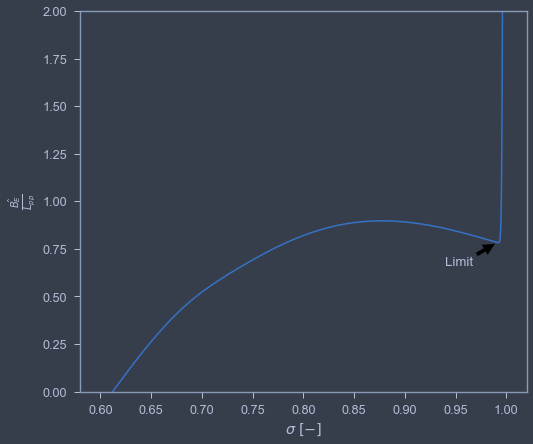

In [155]:
fig,ax=plt.subplots()
df_frame.plot(y='B_E0_s', ax=ax)

ax.set_xlabel(r'$\sigma$ $[-]$')
ax.set_ylabel(r'$\frac{\hat{B_{E}}}{L_{pp}}$')
ax.set_ylim(0,2)
x = 0.99
y = 0.78
ax.annotate('Limit',xy=(x,y), xytext=(0.94,0.85*y), arrowprops=dict(facecolor='black', shrink=0.05))
ax.get_legend().set_visible(False)